In [1]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from covidxpert import load_image, perspective_correction
from covidxpert.utils import add_padding, trim_padding, remove_artefacts

In [2]:
def get_kernel_size(image:np.ndarray)->int:
    kernel_size = int(min(image.shape) / 5)
    
    if kernel_size % 2 == 0:
        kernel_size += 1
        
    return kernel_size

In [3]:
def apply_mean_blur(image:np.ndarray)->np.ndarray:
    return cv2.medianBlur(image, get_kernel_size(image))

In [20]:
def apply_median_threshold(image:np.ndarray)->np.ndarray:
    return cv2.threshold(image, np.median(image)*0.75, 255, cv2.THRESH_BINARY)[1]

In [21]:
def count_from_left_side(mask:np.ndarray):
    counter = 0
    for boolean in mask:
        if boolean:
            counter += 1
        else:
            break
    return counter

In [22]:
def count_from_right_side(mask:np.ndarray):
    return count_from_left_side(np.flip(mask, axis=0))

In [23]:
def build_slice(left:int, right:int, maximum:int):
    return slice(left, maximum if right==0 else right)

In [24]:
def strip_black(image:np.ndarray, mask:np.ndarray, v_threshold:float, h_threshold:float)->np.ndarray:
    vertical_mask = mask.mean(axis=1) <= v_threshold
    horizzontal_mask = mask.mean(axis=0) <= h_threshold
    
    h_slice = build_slice(
        count_from_left_side(horizzontal_mask),
        -count_from_right_side(horizzontal_mask),
        image.shape[1]
    )
    v_slice = build_slice(
        count_from_left_side(vertical_mask),
        -count_from_right_side(vertical_mask),
        image.shape[0]
    )
    return image[v_slice, h_slice]

In [25]:
def compute_median_threshold(mask:np.ndarray)->float:
    masked_mask = strip_black(mask, mask, 0, 0)
    v_white_median = np.median(masked_mask.mean(axis=0))
    h_white_median = np.median(masked_mask.mean(axis=1))
    return v_white_median*0.6, h_white_median*0.6

In [26]:
def normalize_image(image:np.ndarray)->np.ndarray:
    return np.uint8(((image - image.min()) / (image.max() - image.min()))*255)

In [27]:
def get_blur_mask(image:np.ndarray, padding:int):
    blurred = add_padding(image, padding)
    blurred = remove_artefacts(blurred)
    blurred = apply_mean_blur(blurred)
    blurred = apply_median_threshold(blurred)
    return trim_padding(blurred, padding)

In [28]:
def blur_bbox(image:np.ndarray, padding:int=50)->np.ndarray:
    mask = get_blur_mask(image, padding)
    return strip_black(image, mask, *compute_median_threshold(mask))

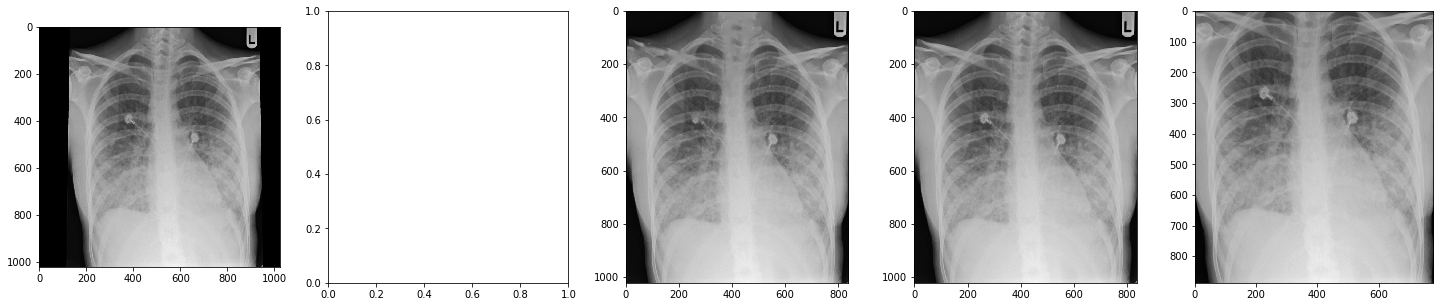

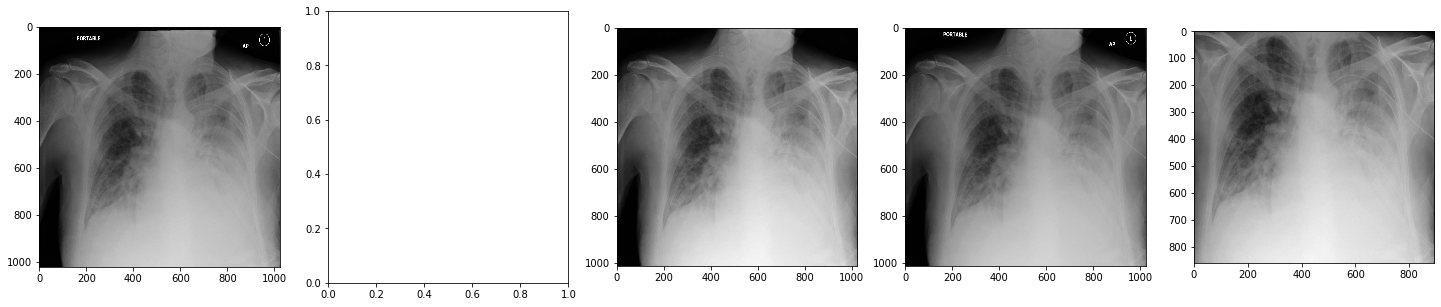

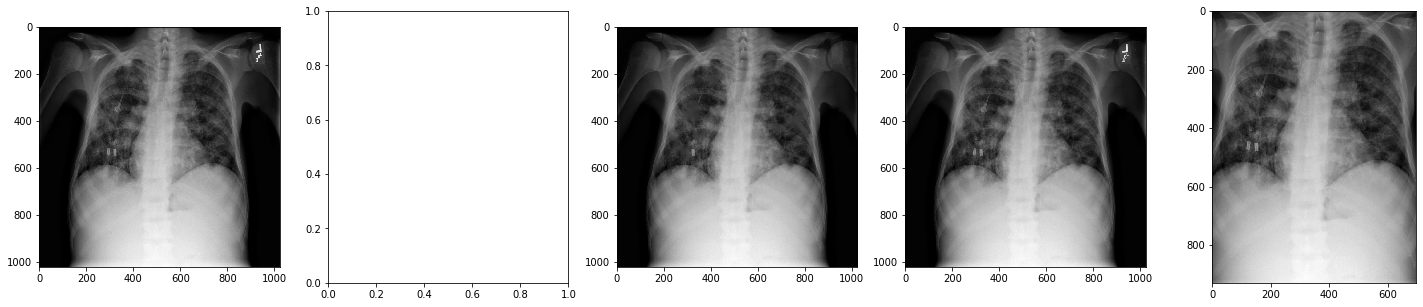

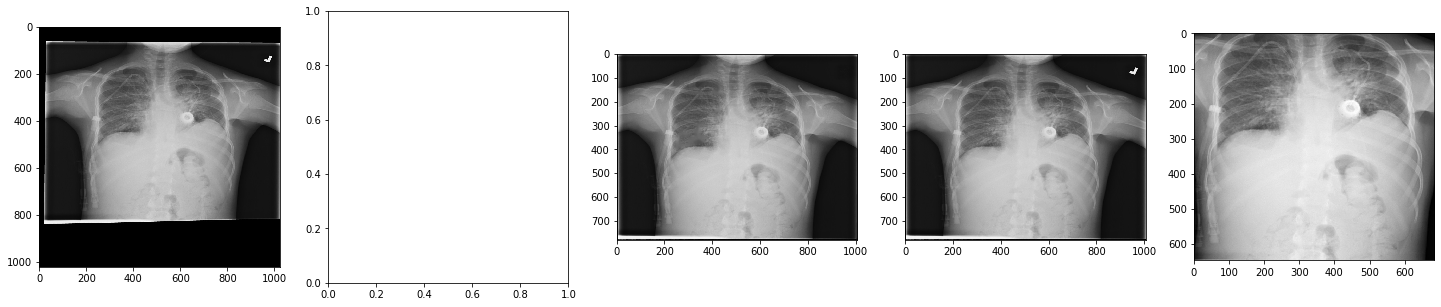

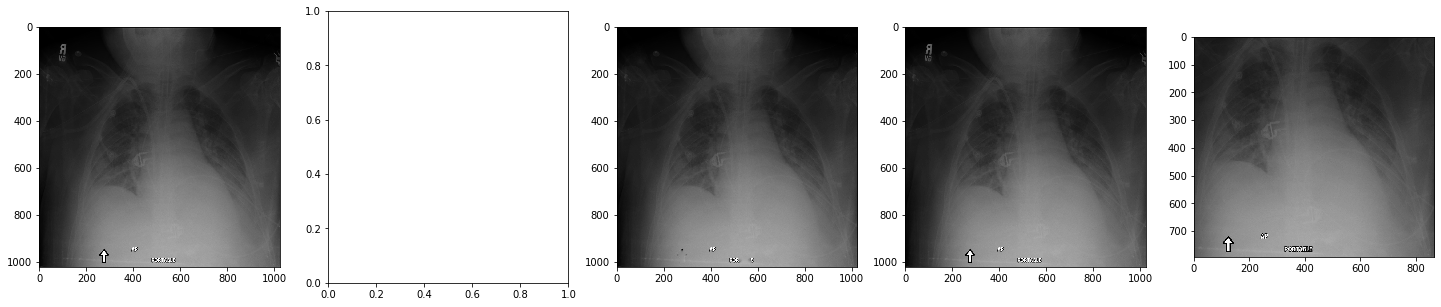

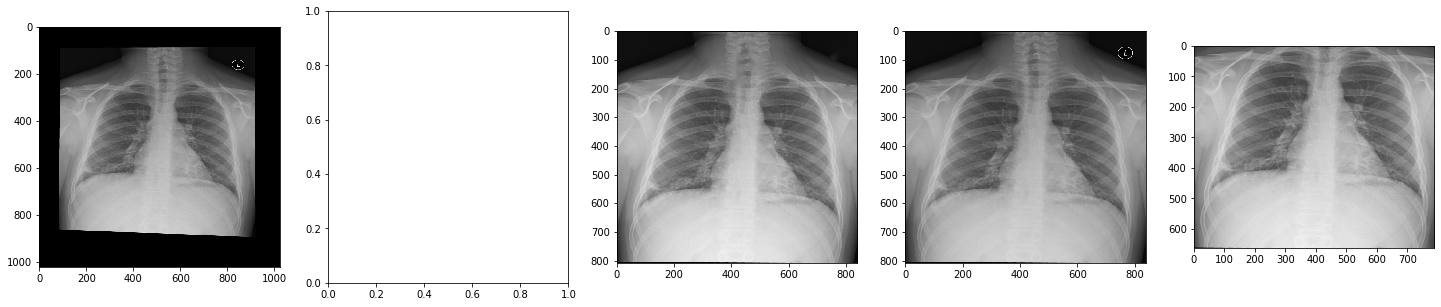

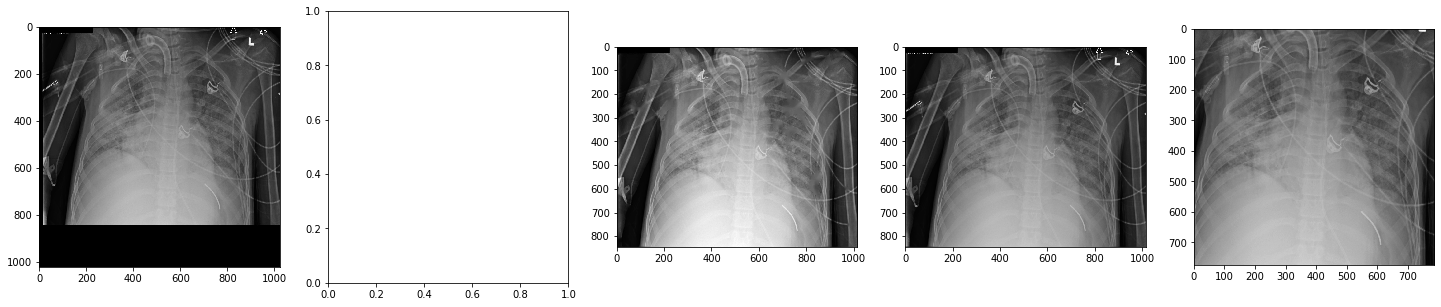

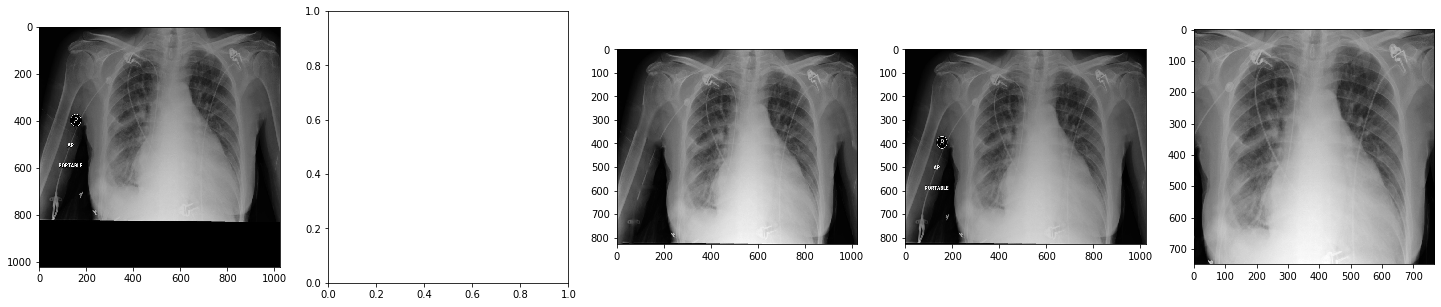

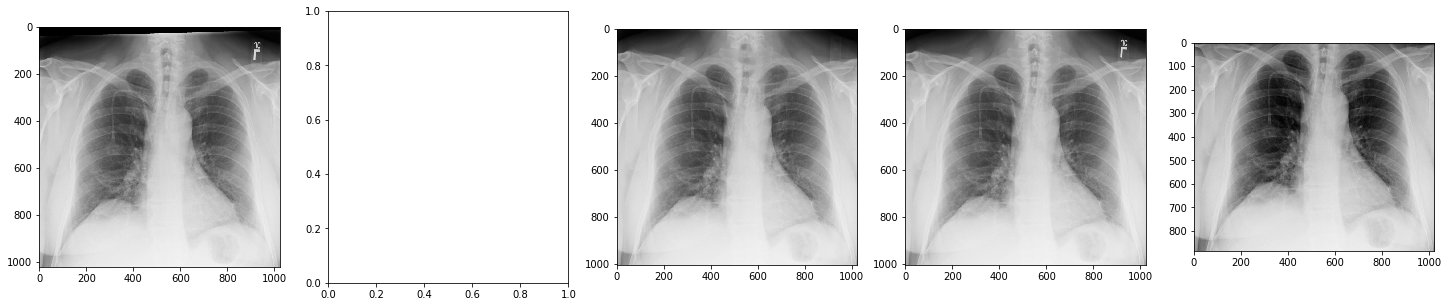

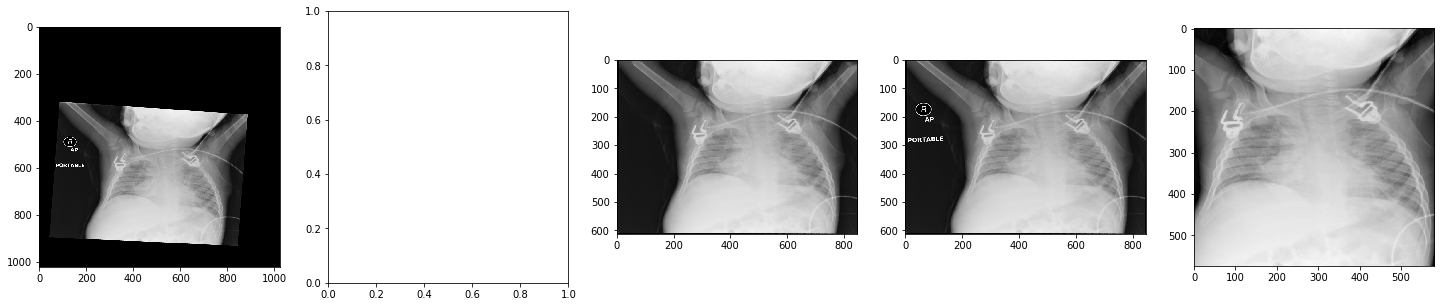

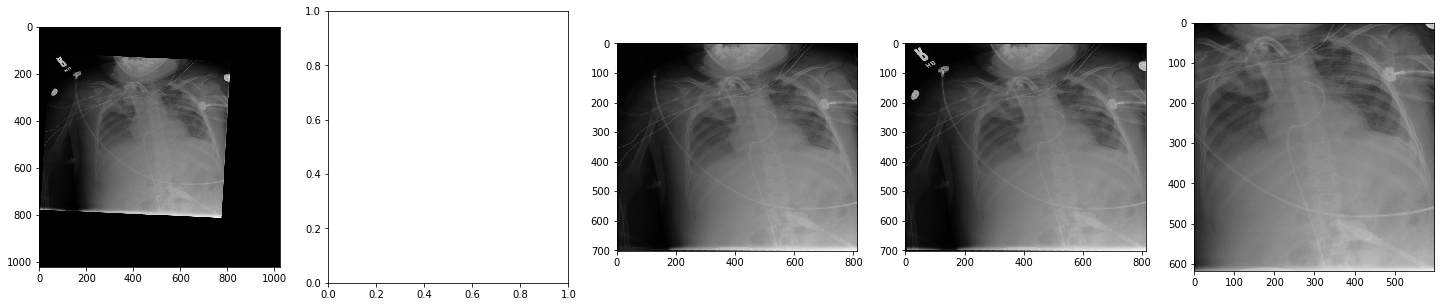

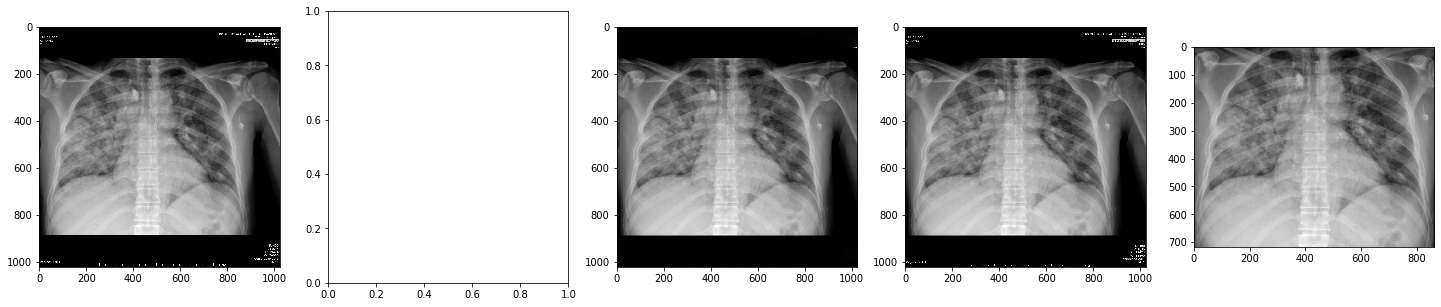

In [29]:
for path in glob("tests/test_images/*.jpg"):
    original = load_image(path)
    image = perspective_correction(original)
    cleared_image = remove_artefacts(image)
    bboxed = blur_bbox(image)
    
    fig, axes = plt.subplots(ncols=5, figsize=(25, 5))
    axes[0].imshow(original, cmap="gray")
    axes[2].imshow(cleared_image, cmap="gray")
    axes[3].imshow(image, cmap="gray")
    axes[4].imshow(bboxed, cmap="gray")
    plt.show()